# EEG Signal Processing using Pytorch Project on CP DSAI Course

The project is to do classification on EEG signal using BCI Motor Imagery Dataset. 

In [ ]:
!pip install mne

     |████████████████████████████████| 7.4 MB 4.4 MB/s 


In [ ]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

from google.colab import drive

# Modeling and training packages
import torch
from torch import nn
import torch.optim as optim

# Data Preparation packages
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

#Configurations
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1. Dataset Retrival

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Because the dataset was loaded to Google drive directory, mounting that directory

Define dataset path. The dataset path should be the path that contains **RECORDS** files and folders referring to each subject

In [ ]:
dataset_path = '/content/drive/MyDrive/CourseWork Resource/CPDSAI/project/files/'

Write the function to do read preprocess and any neccessary steps fot generating raw X and y

In [ ]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Selected Runs: ', runs)
        print('Selected Subjects: ', subjects)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)

        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1  # A second before event cue 
        tmax = 4   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=False, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=0., tmax=4.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False, channels=None):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            if channels is None:
                self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
            else:
                self.epochs = self.epochs.pick_channels(channels)
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False, channels=None):
        self.return_epochs(channel_selection=channel_selection, channels=channels)
        return self.epochs.get_data(), self.labels

To get X and y of Dataset, just simply implement the function

In [ ]:
# Define subject list and runs number
subjects = [i for i in range(1, 11)]
# subjects = []]

# subjects= [1]
# runs = [5,6, 9,10, 13,14]
runs = [3,4, 7,8, 11,12]

freq_select = (0.05, 35)

# initialize dataset
eeg = motorImagery(dataset_path, subjects, runs)

# do filtering frequency
eeg.apply_filter(freq=freq_select)

# gather X and y
X, y = eeg.get_X_y(channel_selection=True)

X.shape

Selected Runs:  [3, 4, 7, 8, 11, 12]
Selected Subjects:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Loading files at index: [2, 3, 6, 7, 10, 11, 16, 17, 20, 21, 24, 25, 30, 31, 34, 35, 38, 39, 44, 45, 48, 49, 52, 53, 58, 59, 62, 63, 66, 67, 72, 73, 76, 77, 80, 81, 86, 87, 90, 91, 94, 95, 100, 101, 104, 105, 108, 109, 114, 115, 118, 119, 122, 123, 128, 129, 132, 133, 136, 137]
Loading file #60/60: /content/drive/MyDrive/CourseWork Resource/CPDSAI/project/files/S010/S010R12.edfUsed Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
900 matching events found
No baseline correction applied
Loading data for 900 events and 801 original time points ...
0 bad epochs dropped


(900, 21, 641)

# 2. Data Preprocessing

This is to prepare CNN data form (if implementing RNN, deactivate this cell)

In [ ]:
X = X[:, np.newaxis,:,:]
X.shape

(900, 1, 21, 641)

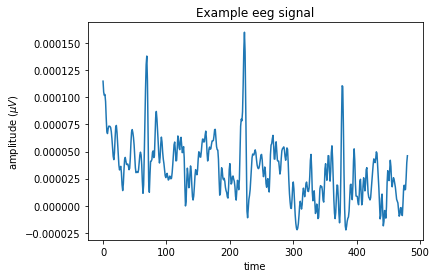

In [ ]:
plt.plot(X[0, 0, 1,:])
plt.title('Example eeg signal')
plt.xlabel('time')
plt.ylabel('amplitude ($\mu V$)' )
plt.show()

Due to small value of EEG signal regarding to X. the values will be scaled up. Actually, the signal values are the micro volt ($10^{-6}$) unit converted to volt. So that, the value should be rescaled to micro volt again to a scale of a unit of +1.0 or -1.0.

In [ ]:
X = X * 1e6
X[0]

array([[[ 19.38349538,   4.14441267,  -4.4116834 , ..., -29.98886252,
         -32.44081055, -35.78884119],
        [  9.75198583, -14.29685263, -21.08580977, ..., -49.70049942,
         -46.78733403, -50.0516023 ],
        [ 11.02501119, -14.13519489, -23.64971797, ..., -47.07360987,
         -41.42462053, -42.19713188],
        ...,
        [ 21.8764033 ,   5.76974334, -10.18594646, ..., -26.0043885 ,
         -31.52801817, -33.90526144],
        [ 10.39369434,  -1.84999502, -16.85236625, ...,   3.81784795,
          -4.84695848,  -7.67911078],
        [ -7.08081241, -13.53146738, -21.00705735, ...,   6.71166798,
           0.68288735,   1.23483417]]])

Next function is to prepare X and y as numpy array into pytorch DataLoader

In [ ]:
def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

Before Loading data into DataLoader, split X and y into train set and test (validation) set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (720, 1, 21, 641)
X_test shape:  (180, 1, 21, 641)
y_train shape:  (720,)
y_test shape:  (180,)


Load training set and test set for DataLoader

In [ ]:
train_loader = Xy_dataloader(X_train, y_train, 32)
test_loader = Xy_dataloader(X_test, y_test, 32)

# 3. Modeling

Modeling section will make spatio-temporal CNN based. 

In [ ]:
class CNNTempoSpatio(nn.Module):
    
    def __init__(self, input_chan, output_dim):
        super().__init__()
        
        self.conv_tempo1 = nn.Sequential(
            nn.Conv2d(input_chan, 8, kernel_size=(1,11), stride=1, padding='valid'),
            nn.LayerNorm((8, 21, 631)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 3), stride=1),
            nn.Dropout2d(0.5)
        )

        self.conv_tempo2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(1,11), stride=1, padding='valid'),
            nn.LayerNorm((16, 21, 619)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 3), stride=1),
            nn.Dropout2d(0.5)
        )

        self.conv_spatio = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(21, 1), stride=1, padding='valid'),
            nn.LayerNorm((32, 1, 617)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1, 15), stride=5),
            nn.Dropout2d(0.5)
        )

        self.fc = nn.Linear(32*121, output_dim)

        
    def forward(self, x):
        
        x = self.conv_tempo1(x)

        x = self.conv_tempo2(x)

        x = self.conv_spatio(x)

        # x = self.avg_pool(x)

        # print(x.shape)

        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x

# 4. Training Model

Before constructing model instance, check wheter GPU is work or not

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('pytorch is using: ', device)

pytorch is using:  cuda


Create Model instance

In [ ]:
model = CNNTempoSpatio(1, 2).to(device)

Define Optimizer and Loss function

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Define Xavier initialization which helps init weight better to prevent model training from gradient vanishing or exploding

In [ ]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here
                
model.apply(initialize_weights)

CNNTempoSpatio(
  (conv_tempo1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(1, 11), stride=(1, 1), padding=valid)
    (1): LayerNorm((8, 21, 631), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (conv_tempo2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(1, 11), stride=(1, 1), padding=valid)
    (1): LayerNorm((16, 21, 619), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 3), stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (conv_spatio): Sequential(
    (0): Conv2d(16, 32, kernel_size=(21, 1), stride=(1, 1), padding=valid)
    (1): LayerNorm((32, 1, 617), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 15), stride=5, padding=0)
    (4): Dropout2d(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=3872, out_features

Lets define the training function with validation set

In [ ]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()

            clipping_value = 0.9 # arbitrary value of your choosing
            torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

Train model

epoch 200/200 train loss: 0.14378 train acc: 94.8611068725586 validation loss: 0.45651 validation acc: 81.11112213134766


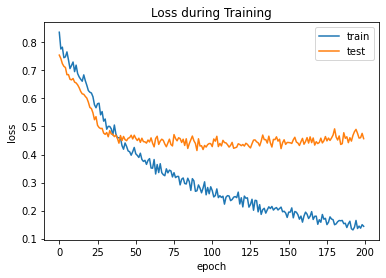

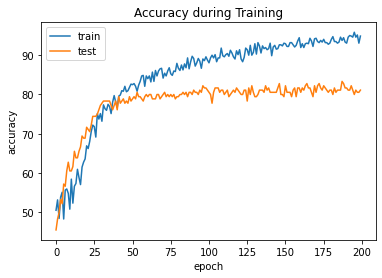

In [ ]:
model, loss_train, loss_valid, acc_train, acc_valid = train_model(model, train_loader, test_loader, 200, criterion, optimizer, 1)

# 5. Model Evaluation

In [ ]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [ ]:
y_pred = predict_model(model, X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       400
           1       0.61      0.65      0.63       407

    accuracy                           0.61       807
   macro avg       0.61      0.61      0.61       807
weighted avg       0.61      0.61      0.61       807



Unmount the drive

In [ ]:
drive.flush_and_unmount()